# Exercise Set 13: Network formation


In this Exercise Set 13 we will investigate network formation among high school pupils. 

## Part 1: Network formation


Load the data using the script below. Read a bit about the dataset [here](http://www.sociopatterns.org/datasets/high-school-contact-and-friendship-networks/) to get an understanding of what is in each variable. 

The script gives you two dataframes to work with: 
 > `el`, which is an edge-list 
 >
 > `ind` which contains individual characteristics

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline

url_base = 'http://www.sociopatterns.org/wp-content/uploads/2015/'

# edgelist
url_el = url_base + '07/High-School_data_2013.csv.gz'
col_names_el = ['timestamp', 'u1', 'u2', 'class1', 'class2']
el = pd.read_csv(url_el, header=None, names=col_names_el, delimiter=' ')

# individual characteristics
url_ind = url_base + '09/metadata_2013.txt'
col_names_ind = ['u', 'class', 'gender']
ind = pd.read_csv(url_ind, header=None, names=col_names_ind, delimiter='\t')\
            .set_index('u')

# remove observation with missing gender
has_gender = ind[ind.gender!='Unknown'].index

# DataFrames
ind = ind.loc[has_gender].copy()
el = el[el.u1.isin(has_gender) &  el.u2.isin(has_gender)].copy()

> **Ex. 13.1.1**: Describe the edgelist columns content. Parse the timestamp. What is the resolution of meetings? Use the parsed timestamp to count the meetings by hour in local time.

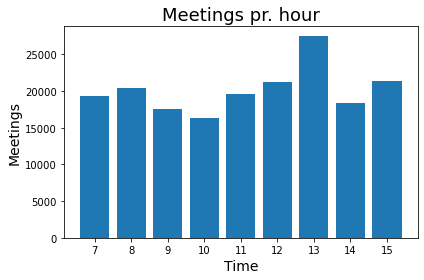

In [2]:
el['time'] = pd.to_datetime(el.timestamp, unit = 's')

plt.bar(el.time.dt.hour.unique(), el.time.dt.hour.value_counts().sort_index())
plt.xticks(np.arange(min(el.time.dt.hour.unique()), max(el.time.dt.hour.unique()+1)))
plt.xlabel('Time', size = 14)
plt.ylabel('Meetings', size = 14)
plt.title('Meetings pr. hour', size = 18)
plt.tight_layout()
plt.show()

> **Ex. 13.1.2**: Count the number of meetings for each edge and save this as a DataFrame called `el_agg`. Filter out edges with less than 5 minutes of meetings. Attach the gender and class of both nodes.

In [3]:
el_agg = el.groupby(['u1','u2']).size().rename('n_meetings').reset_index()

el_agg = el_agg.merge(ind.add_suffix('1') , left_on = 'u1', right_on = 'u')
el_agg = el_agg.merge(ind.add_suffix('2') , left_on = 'u2', right_on = 'u')
el_agg = el_agg[el_agg.n_meetings >= 15] # Each meeting is 20s
el_agg.head()

,u1,u2,n_meetings,class1,gender1,class2,gender2
3,27,63,19,2BIO2,M,2BIO3,F
13,70,101,15,2BIO3,F,2BIO3,F
17,55,106,28,2BIO3,F,2BIO3,F
20,101,106,23,2BIO3,F,2BIO3,F
21,1,117,18,2BIO3,M,2BIO3,M


> **Ex. 13.1.3**: Answer question in the function `fraction_triangles` below. Explain how `fraction_triangles` is related to  computing the clustering coefficient (using `nx.average_clustering`).
>
>> *Hint:* The following code does the same thing as `fraction_triangles`, but at a scale where you can understand what's going on. If you have a hard time understanding the code in the function you can try to play around with this simpler example
>>
>> ```python
>> import networkx as nx 
>>
>> A  = np.array(
>>     [[0, 1, 1, 0],
>>      [1, 0, 1, 0],
>>      [1, 1, 0, 1],
>>      [0, 0, 1, 0]]
>> )
>>
>> G = nx.from_numpy_array(A)
>> nx.draw(G,with_labels=True)
>>
>> def nth(A, n):
>>     A_ = A.copy()    
>>     for _ in range(1,n):
>>         A = A.dot(A_)
>>     return A
>>
>> a_t = nth(A,3).diagonal().sum()/6
>> n = len(A[:,0])
>> p_t = binom(n, 3)
>> ```


In [4]:
def make_net(el_, nodes):
    '''
    Convert edgelist to networkx graph which is 
    binary and undirected.
    
    Parameters
    ----------
    el_ : DataFrame
        Table containing an edgelist with columns 
        `u1` and `u2` which are the nodes in the edge.
        
    nodes : array-like
        1d array containing the node identities.
    '''    
    
    nx_input = el_, 'u1', 'u2', 'n_meetings', nx.Graph()
    g = nx.from_pandas_edgelist(*nx_input)
    g.add_nodes_from(nodes)
    return g

In [5]:
from scipy.special import binom

def fraction_triangles(el_, nodes):
    '''
    Compute fraction of actual triangles out 
    of the potential triangles.
    
    Parameters
    ----------
    el_ : DataFrame
        Table containing an edgelist with columns 
        `u1` and `u2` which are the nodes in the edge.
        
    nodes : array-like
        1d array containing the node identities.
    '''
    
    g = make_net(el_, nodes)
    
    #Q.1: what is `A`?: the adjacency matrix which is symmetric and binary
    #Q.2: what does `A**3` do? compute the number of paths between two nodes
    #Q.3: what is diagonal of A_t? the number of actual paths of length 3, 
    # i.e. triangles, which include the person. these are called cycles
    # because they start and end at the same person
    
    # count actual triangles    
    A = nx.to_scipy_sparse_matrix(g)
    A_t = A**3
    a_t = A_t.diagonal().sum()/6
    
    #Q.4: what does `binom(n,3)` compute? the number of triangles including the person
    
    # count potential triangles
    n = len(g.nodes())
    p_t = binom(n, 3)
        
    return a_t/p_t

> **Ex. 13.1.4**: Apply the function `fraction_triangles` to `el_agg` and print the triangle fraction in the network. Next remove all edges that go between classes. Compute triangle fraction within each class and store it. Compute the mean within class triangles and bootstrap the standard error of the mean. Comment on the output.
>
>> *Hint:* To bootstrap an estimate draw $k>>0$ samples with replacement from the data. Compute the estimate on each of these samples and average them in the end to get the bootstrapped estimate. 

>> **Answer: Ex. 13.1.4**
<br>
>> We start by computing the overall mean:

In [6]:
print(f'Triangle fraction: {fraction_triangles(el_agg, ind.index)}') 

Triangle fraction: 0.00030148894177744237


>> We then wanna generate a data set where each edge is only within class. In other words, the triangle fraction within each class:

In [7]:
el_agg_class = el_agg[el_agg.class1 == el_agg.class2]

classes = el_agg_class.class1.unique()

triangles = []

for i in classes:
    fraction = fraction_triangles(dict(tuple(el_agg_class.groupby('class1')))[i],
                                             dict(tuple(ind.groupby('class')))[i].index)
    triangles.append(fraction)


>> Given the list of triangles for each class in `triangles`, we can calculate the mean across classes:

In [8]:
from statistics import mean 

print(f'Mean within classes: {mean(triangles)}')

Mean within classes: 0.022109699854589965


>> Which naturally is quite a lot larger. This is quite intuitive, as we would expect people to have more frequent (and longer) interactions with people they share a classroom with. With bootstrapping we can find the std. error of the mean:

In [9]:
def bootstrap(df, n_iter):
    std = np.std([pd.Series(triangles).sample(frac = 1, replace = True).mean() for _ in range(n_iter)])
    return std

print(f'Std. Error of mean within classes: {bootstrap(triangles, 10000)}')

Std. Error of mean within classes: 0.002762267281612377


Recall from class that we can define the following measures of homophily. We define **homophily index** inspired by [Currarini et al. (2009)](https://doi.org/10.2139/ssrn.1021650):
- share of edges that are same type: $H = \frac{s}{s+d}$
- possible range [0,1]


We define **baseline homophily** as: 
- We count fraction of potential edges in population of nodes which are same type:

\begin{equation}B=\frac{\sum_t\#potential(n_t)}{\#potential(n)}, \qquad \#potential(k)=\frac{k\cdot(k-1)}{2}\end{equation}

- Interpretation: Expected homophily from random link formation.     

We define **inbreeding homophily** as:      

\begin{equation}IH=\frac{H-B}{1-B}\end{equation}


> **Ex. 13.1.5**: Compute the inbreeding homophily for each class. Use the class measures to compute the mean. Use a bootstrap to compute whether there is inbreeding homophily.

> **Ex. 13.1.6** (BONUS): Describe what an unsupported edge is. Construct a test of whether there is a preference for forming  triangles within same gender than across.
>
>> *Hint:*  You can find inspiration in the approach of [Chandrasekhar, Jackson (2018)](https://web.stanford.edu/~arungc/CJ_sugm.pdf) pp. 31-35. They construct an almost identical test for triangle formation across castes in Indian villages.

In [ ]:
# [Answer to ex. 13.1.6 here]